## MicroSAM APG demo

This notebook runs MicroSAM's Automatic Prompt Generator (APG) to produce instance segmentations from an image.

What to do:
- Update the image path in the first code cell to point to your local image folder.
- Run the cells in order: load image → initialize APG → generate masks → visualize in Napari.

This notebook is a compact demo (no model training).

# Predict MicroSAM (APG demo)

Minimal demo that loads an image, initializes the MicroSAM APG, runs automatic instance segmentation, and visualizes results. Keep experiments small when trying new parameters.

Image shape: (1536, 2040, 3)


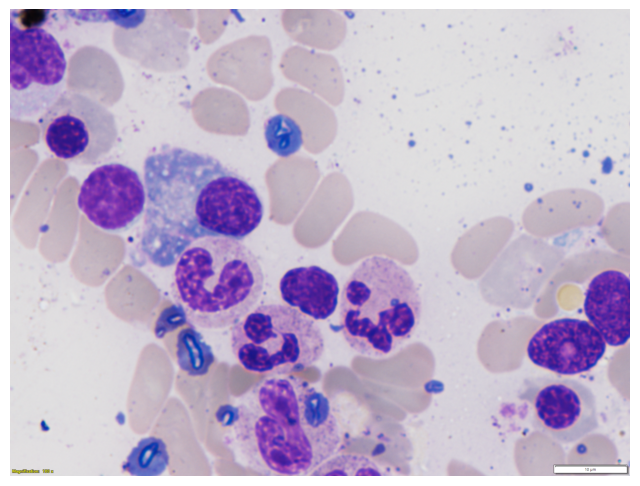

<Image layer 'image' at 0x776cfd312950>

In [13]:
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt

# Update these paths for your environment
tnia_images_path = Path("/home/bnorthan/images")
parent_path = Path(tnia_images_path / "tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set")
img_name = "TestHidden_005.bmp"

# Load image
img = imread(parent_path / img_name)
print('Image shape:', img.shape)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(img)
plt.show()

import napari
viewer = napari.Viewer()
viewer.add_image(img.mean(axis=-1), name='image')

In [14]:
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation
from micro_sam.instance_segmentation import AutomaticPromptGenerator, get_predictor_and_decoder

# Choose a MicroSAM model variant (example: 'vit_b_lm')
model_type = "vit_b_lm"
# Create predictor and decoder, then an AutomaticPromptGenerator (APG) segmenter
predictor, decoder = get_predictor_and_decoder(model_type=model_type)
segmenter = AutomaticPromptGenerator(predictor, decoder)


In [15]:
import torch
tile_shape = None #(384, 384)
halo = (64, 64)

device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
# Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
predictor, segmenter = get_predictor_and_segmenter(
    model_type=model_type, # choice of the Segment Anything model
    #checkpoint=best_checkpoint,  # overwrite to pass your own finetuned model.
    device=device,  # the device to run the model inference.
    is_tiled = False #(tile_shape is not None),  # whether the model is tiled or not.
)

In [16]:
'''
------------- generate API -------------

def generate(
	self,
	min_size: int = 25,
	center_distance_threshold: float = 0.5,
	boundary_distance_threshold: float = 0.5,
	foreground_threshold: float = 0.5,
	multimasking: bool = False,
	batch_size: int = 32,
	nms_threshold: float = 0.9,
	intersection_over_min: bool = False,
	output_mode: str = 'instance_segmentation',
	mask_threshold: Union[float, str, NoneType] = None,
	refine_with_box_prompts: bool = False,
	prompt_function: Optional[<built-in function callable>] = None
) -> Union[List[Dict[str, Any]], numpy.ndarray]:
'''

"\n------------- generate API -------------\n\ndef generate(\n\tself,\n\tmin_size: int = 25,\n\tcenter_distance_threshold: float = 0.5,\n\tboundary_distance_threshold: float = 0.5,\n\tforeground_threshold: float = 0.5,\n\tmultimasking: bool = False,\n\tbatch_size: int = 32,\n\tnms_threshold: float = 0.9,\n\tintersection_over_min: bool = False,\n\toutput_mode: str = 'instance_segmentation',\n\tmask_threshold: Union[float, str, NoneType] = None,\n\trefine_with_box_prompts: bool = False,\n\tprompt_function: Optional[<built-in function callable>] = None\n) -> Union[List[Dict[str, Any]], numpy.ndarray]:\n"

In [17]:
# Initialize the segmenter on the loaded image and run a single, explicit generation call
segmenter.initialize(image=img)

# Single result variable (use binary masks for downstream visualization/stacking)
mask_list = segmenter.generate(output_mode='binary_mask')
print('mask_list ->', type(mask_list), 'len=', len(mask_list) if hasattr(mask_list, '__len__') else None)


mask_list -> <class 'list'> len= 18


In [18]:
mask_list[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
       shape=(1536, 2040)),
 'area': np.float64(12817.0),
 'bbox': [171, 275, 0, 63],
 'crop_box': [0, 2040, 0, 1536],
 'seg_id': 1}

In [19]:
from segment_everything.stacked_labels import StackedLabels
stacked_labels = StackedLabels(mask_list)
labels=stacked_labels.get_3d_labels()

In [20]:
viewer.add_labels(labels, name='labels', scale=(3,1,1))

<Labels layer 'labels' at 0x776cdc256a90>

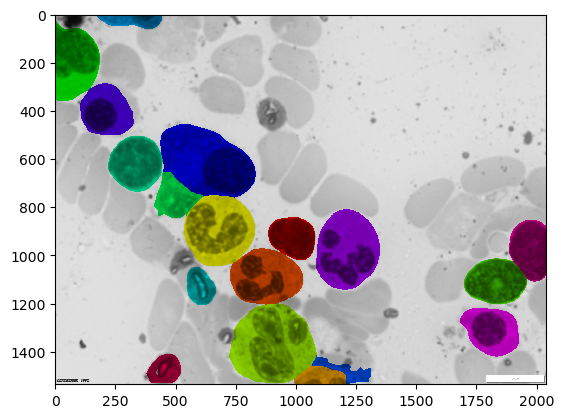

In [21]:
from tnia.plotting.plt_helper import mask_overlay

labels_2d = stacked_labels.make_2d_labels(type="max")

plt.imshow(mask_overlay(img, labels_2d))